In [3]:
import os 
import PIL
import torch
import pandas
import torchvision 
import matplotlib.pyplot as plt

# 数据集路径
train_path = './train'
test_path = './test'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_path:str, train=True, transform=None):
        self.data_path = data_path
        self.train_flag = train
        if transform is None:
            self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size = (224,224)),       #尺寸规范
                torchvision.transforms.ToTensor(),                     #转化为tensor
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
            ])
        else:
            self.transform = transform
        self.path_list = os.listdir(data_path) # 列出所有图片命名
    def __getitem__(self, idx: int):
        
        img_path = self.path_list[idx]
        if self.train_flag is True:
            # 例如 img_path 值 cat.10844.jpg -> label = 0
            if img_path.split('.')[0] == 'dog' : 
                label = 1
            else:
                label = 0
        else:
            label = int(img_path.split('.')[0])          # 获取test数据的编号
        label = torch.tensor(label, dtype=torch.int64)   # 把标签转换成int64
        img_path = os.path.join(self.data_path, img_path)# 合成图片路径
        img = PIL.Image.open(img_path)   # 读取图片
        img = self.transform(img)        # 把图片转换成tensor
        return img, label
    def __len__(self) -> int:
        return len(self.path_list)       # 返回图片数量
train_datas = MyDataset(train_path)
test_datas = MyDataset(test_path,train=False)

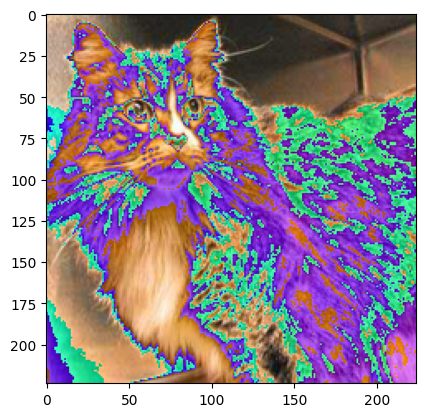

In [11]:
# 展示读取的图片数据，因为做了归一化，所有图片显示不正常。
Img_PIL_Tensor = train_datas[100][0]      
new_img_PIL = torchvision.transforms.ToPILImage()(Img_PIL_Tensor).convert('RGB')
plt.imshow(new_img_PIL)
plt.show()

In [12]:
# 70%训练集  30%测试集
train_size = int(0.7 * len(train_datas))
validate_size = len(train_datas) - train_size
train_datas,validate_datas = torch.utils.data.random_split(train_datas,[train_size, validate_size])

# 数据分批  
# batch_size=32 每一个batch大小为32
# shuffle=True 打乱分组
# pin_memory=True 锁页内存，数据不会因内存不足，交换到虚拟内存中，能加快数据读入到GPU显存中.
# num_workers 线程数。 num_worker设置越大，加载batch就会很快，训练迭代结束可能下一轮batch已经加载好
# win10 设置会多线程可能会出现问题，一般设置0.
train_loader = torch.utils.data.DataLoader(train_datas, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
validate_loader = torch.utils.data.DataLoader(validate_datas, batch_size=32,
                                            shuffle=True, pin_memory=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_datas, batch_size=32,
                                            shuffle=False, pin_memory=True, num_workers=0)

In [16]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(torch.nn.ReLU())
        in_channels = out_channels
    # ceil_mode=False 输入的形状不是kernel_size的倍数，直接不要。
    # ceil_mode=True 输入的形状不是kernel_size的倍数，单独计算。
    layers.append(torch.nn.MaxPool2d(kernel_size=2,stride=2,ceil_mode=False))
    return torch.nn.Sequential(*layers)
def vgg(conv_arch):
    conv_blks = []
    # 数据输入是几个通道
    in_channels = 3
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
        
    return torch.nn.Sequential(
        *conv_blks,torch.nn.Flatten(),
        torch.nn.Linear(out_channels * 7 * 7, 4096), torch.nn.ReLU(), torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 4096), torch.nn.ReLU(), torch.nn.Dropout(0.5),
        torch.nn.Linear(4096, 2))

In [17]:
# VGG11，VGG13，VGG16，VGG19 可自行更换。
conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))  # vgg16
#conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  # vgg11
#conv_arch = ((2, 64), (2, 128), (2 , 256), (2, 512), (2, 512))  # vgg13
#conv_arch = ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))  # vgg19
net = vgg(conv_arch)   # 定义网络
net = net.to(device)   # 把网络加载到GPU上

# Xavier方法 初始化网络参数，最开始没有初始化一直训练不起来。
def init_normal(m):
    if type(m) == torch.nn.Linear:
        # Xavier初始化
        torch.nn.init.xavier_uniform_(m.weight)    
        torch.nn.init.zeros_(m.bias)
    if type(m) == torch.nn.Conv2d:
        # Xavier初始化
        torch.nn.init.xavier_uniform_(m.weight)    
        torch.nn.init.zeros_(m.bias)
net.apply(init_normal)

learn_rate = 1e-5
#momentum = 0.9                         
#optimizer = torch.optim.SGD(net.parameters(), learn_rate, momentum = momentum) #定义梯度优化算法
optimizer = torch.optim.Adam(net.parameters(), learn_rate) #开始使用SGD没有训练起来，才更换的Adam
cost = torch.nn.CrossEntropyLoss(reduction='sum')     # 定义损失函数，返回batch的loss和。
print(net)    # 打印模型架构

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
   

In [18]:
epoch = 30 # 迭代30次
def train_model(net, train_loader, validate_loader, cost, optimezer):
    net.train()       # 训练模式
    now_loss = 1e9    # flag 计算当前最优loss   
    train_ls = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    for i in range(epoch):
        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for j, (data, label) in enumerate(train_loader):
            data, label = data.to(device), label.to(device)
            pre = net(data)
            # 计算当前batch预测正确个数
            correct_epoch += torch.sum(pre.argmax(dim = 1).view(-1) == label.view(-1)).item()
            loss = cost(pre, label)
            loss_epoch += loss.item()
            optimezer.zero_grad()
            loss.backward()
            optimezer.step() 
            if j%100 == 0:
                print(f'batch_loss:{loss.item()}, batch_acc:{torch.sum(pre.argmax(dim = 1).view(-1) == label.view(-1)).item()/len(label)}%')
        train_ls.append(loss_epoch/train_size)
        train_acc.append(correct_epoch/train_size)
        
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            loss_validate = 0.
            correct_validate = 0
            for j, (data, label) in enumerate(validate_loader):
                data, label = data.to(device), label.to(device)
                pre = net(data)
                correct_validate += torch.sum(pre.argmax(dim = 1).view(-1) == label.view(-1)).item()
                loss = cost(pre, label)
                loss_validate += loss.item()
           # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            print(f'validate_Loss:{loss_validate/validate_size},  validate_Acc:{correct_validate/validate_size}%')
            
            #保存当前最优模型参数
            if now_loss > loss_validate:
                now_loss = loss_validate
                print("保存模型参数。。。。。。。。。。。")
                torch.save(net.state_dict(), 'model.params')
    # 画图
    plt.plot(range(epoch), train_ls, color = 'b',label = 'loss')
    plt.plot(range(epoch), train_acc, color = 'g',label = 'acc')
    plt.legend()
    plt.show()   #显示 lable 
train_model(net, train_loader, validate_loader, cost, optimizer)

KeyboardInterrupt: 

In [ ]:
# 测试 生成提交submission.csv
def submission(net, test_loader):   
    net.load_state_dict(torch.load('model.params'))
    net = net.to(device) 
    result = []   
    with torch.no_grad():  # 不更新梯度
        for i, data in enumerate(test_loader, 0):            
            images, labels = data[0].to(device), data[1].to(device)
            pre = net(images)
            # 获取 图片是狗的概率
            predicted = torch.nn.functional.softmax(pre, dim=1)[:, 1]    
            # 把预测结果用 list保存
            for j in range(len(predicted)):
                result.append({
                    "id": labels[j].item(),
                    "label": predicted[j].item()
                })
    # 把 list 转成 dataframe 然后保存为csv文件
    columns = result[0].keys()
    print(columns)
    result_dict = {col: [anno[col] for anno in result] for col in columns}
    print(result_dict)
    result_file = pandas.DataFrame(result_dict)
    result_file = result_file.sort_values("id")
    result_file.to_csv('./submission.csv', index=None)
submission(net, test_loader)